In [1]:
symbol = "AAPL"

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
stock = yf.Ticker(symbol)
stock = stock.history(period = "max")
stock.index = pd.to_datetime(stock.index)
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-11 00:00:00-04:00,168.339996,175.460007,168.160004,175.039993,91070300,0.0,0.0
2024-04-12 00:00:00-04:00,174.259995,178.360001,174.210007,176.550003,101593300,0.0,0.0
2024-04-15 00:00:00-04:00,175.360001,176.630005,172.500000,172.690002,73531800,0.0,0.0


<Axes: xlabel='Date'>

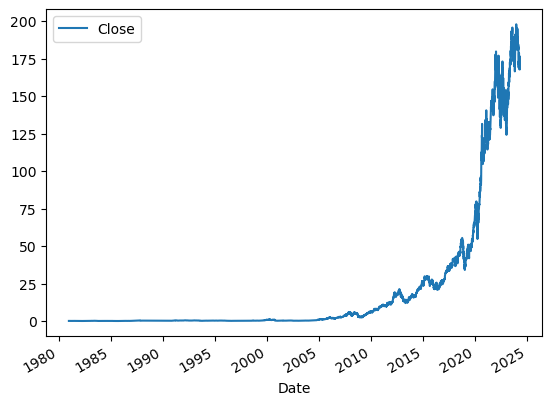

In [4]:
stock.plot.line(y="Close", use_index=True)

In [5]:
del stock['Dividends']
del stock['Stock Splits']

In [6]:
stock["Tomorrow"] = stock["Close"].shift(-1)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)
stock = stock.loc["2000-01-01":].copy()
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.792742,0.850379,0.768648,0.846127,535796800,0.774790,0
2000-01-04 00:00:00-05:00,0.818254,0.836206,0.764869,0.774790,512377600,0.786128,1
2000-01-05 00:00:00-05:00,0.784238,0.835733,0.778569,0.786128,778321600,0.718098,0
2000-01-06 00:00:00-05:00,0.802191,0.808805,0.718098,0.718098,767972800,0.752113,1
2000-01-07 00:00:00-05:00,0.729436,0.763452,0.721878,0.752113,460734400,0.738885,0
...,...,...,...,...,...,...,...
2024-04-11 00:00:00-04:00,168.339996,175.460007,168.160004,175.039993,91070300,176.550003,1
2024-04-12 00:00:00-04:00,174.259995,178.360001,174.210007,176.550003,101593300,172.690002,0
2024-04-15 00:00:00-04:00,175.360001,176.630005,172.500000,172.690002,73531800,169.380005,0


In [7]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [8]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [9]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [10]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,0.307648,0.316114,0.307497,0.314149,103695200,0.319743,1,1.008983,2.0,1.033316,3.0,0.951842,28.0,1.123531,129.0,0.801992,471.0
2003-12-29 00:00:00-05:00,0.316114,0.319894,0.315358,0.319743,233458400,0.321708,1,1.008825,2.0,1.036766,4.0,0.968363,29.0,1.141855,129.0,0.817223,472.0
2003-12-30 00:00:00-05:00,0.320196,0.325034,0.319743,0.321708,204853600,0.323068,1,1.003063,2.0,1.028715,4.0,0.974619,29.0,1.147266,129.0,0.823222,472.0
2003-12-31 00:00:00-05:00,0.322766,0.325487,0.320196,0.323068,174451200,0.321708,0,1.002110,2.0,1.017716,5.0,0.979429,29.0,1.150513,129.0,0.827540,473.0
2004-01-02 00:00:00-05:00,0.325789,0.328813,0.320196,0.321708,144642400,0.335163,1,0.997890,1.0,1.005101,4.0,0.976752,28.0,1.144096,129.0,0.824965,472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11 00:00:00-04:00,168.339996,175.460007,168.160004,175.039993,91070300,176.550003,1,1.021177,1.0,1.029018,3.0,0.975118,25.0,0.968295,126.0,1.188268,522.0
2024-04-12 00:00:00-04:00,174.259995,178.360001,174.210007,176.550003,101593300,172.690002,0,1.004295,2.0,1.029458,3.0,0.984069,26.0,0.976384,127.0,1.197630,522.0
2024-04-15 00:00:00-04:00,175.360001,176.630005,172.500000,172.690002,73531800,169.380005,0,0.988947,1.0,1.001996,3.0,0.963959,25.0,0.954861,126.0,1.170607,522.0


In [11]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=60, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"] + new_predictors
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=60, n_estimators=300, random_state=1)

In [12]:
predictions = backtest(stock, model, new_predictors)

In [13]:
predictions["Predictions"].value_counts()

Predictions
0.0    2122
1.0     489
Name: count, dtype: int64

In [14]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5071574642126789

In [15]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.52432
0    0.47568
Name: count, dtype: float64

In [16]:
predictions.tail(30)

,Target,Predictions
Date,,
2024-03-06 00:00:00-05:00,0,1.0
2024-03-07 00:00:00-05:00,1,0.0
2024-03-08 00:00:00-05:00,1,0.0
2024-03-11 00:00:00-04:00,1,0.0
2024-03-12 00:00:00-04:00,0,0.0
2024-03-13 00:00:00-04:00,1,0.0
2024-03-14 00:00:00-04:00,0,0.0
2024-03-15 00:00:00-04:00,1,0.0
2024-03-18 00:00:00-04:00,1,0.0
